<a href="https://colab.research.google.com/github/RayCyder/Intro/blob/main/ResNet_Implementation_on_CIFAR10_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##The Resnet Research paper can be accessed from here https://arxiv.org/pdf/1512.03385v1.pdf

In [1]:
'''ResNet in PyTorch.

For Pre-activation ResNet, see 'preact_resnet.py'.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

# test()

In [2]:
import torch
import random
import numpy as np
seed_seed =777 #555 #4242 42
random.seed(seed_seed)
torch.manual_seed(seed_seed)
torch.cuda.manual_seed_all(seed_seed)
np.random.seed(seed_seed)


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models

# choose device
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")
if device == "cuda":
    import torch.backends.cudnn as cudnn
    cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

Using device: cuda


In [4]:
from torchvision import datasets
trainset_full = datasets.CIFAR10(root="./data", train=True, download=True)
classes = trainset_full.classes

Files already downloaded and verified


In [5]:
import time
import torch
class BaseOptimizer(object):
  def __init__(self,model,criterion,epochs):
    self.model = model
    self.epochs = epochs
    self.criterion = criterion
    self.optimizer,self.scheduler = None, None
  def initialize_optimzer(self):
    raise Exception("non implemetation")
  def zero_grad(self,inputs=None,labels=None):
    self.optimizer.zero_grad()
  def step(self):
    self.optimizer.step()
  def epoch_step(self):
    if self.scheduler:
      self.scheduler.step()
@torch.no_grad()
def val_once(model, criterion, val_loader):
  model.eval()
  val_loss = 0.0
  with torch.no_grad():
    for inputs, labels in val_loader:
      inputs, labels = inputs.to(device),labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs,labels)
      val_loss += loss.item()
  val_loss = val_loss/max(1,len(val_loader))
  return val_loss
def train_once(model,criterion,optimizer,train_loader,val_loader,learning_rate,epochs=100):
  losses = []
  val_losses = []
  accs =[]
  elapsed_all = []
  #optimizer = MuonMVR2Optimizer(model,criterion,epochs)
  #optimizer.initialize_optimizer(learning_rate)
  start = time.time()
  for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad(inputs, labels)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
    # step the scheduler once per epoch
    optimizer.epoch_step()
    losses.append(running_loss/max(1, len(train_loader)))
    current_lr = optimizer.scheduler.get_last_lr()[0]  # single param group
    #val_loss = val_once(model,criterion,val_loader)
    val_loss, acc = test_model(model, criterion, val_loader)
    val_losses.append(val_loss)
    accs.append(acc)
    elapsed = time.time() - start
    elapsed_all.append(elapsed)
    print(f"[{epoch+1}] time: {elapsed} loss: {losses[-1]:.3f} val_loss:{val_loss} current_lr={current_lr:.6f}")

  print(f"Training finished!")
  return losses, val_losses, accs, elapsed_all

  # track test loss
@torch.no_grad()
def test_model(ResNet18, criterion, test_loader):
  test_loss = 0.0
  class_correct = [0 for _ in range(10)]
  class_total   = [0 for _ in range(10)]

  ResNet18.eval()
  # iterate over test data
  for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    data, target = data.to(device), target.to(device)
    count = data.size(0)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = ResNet18(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target)
    # correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(count):
      label = target.data[i]
      class_correct[label] += int(correct_tensor[i].item())
      class_total[label] += 1

  # average test loss
  total_samples = sum(class_total)
  test_loss = test_loss/max(1,  len(test_loader))
  print('Test Loss: {:.6f}\n'.format(test_loss))

  for i in range(10):
    if class_total[i] > 0:
      acc_i = 100 * class_correct[i] / class_total[i]
      print('Test Accuracy of %5s: %2d%% (%d/%d)' % (
          classes[i],acc_i ,
          class_correct[i], class_total[i]))
    else:
      print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
  acc = 100. * np.sum(class_correct) / total_samples
  print('\nTest Accuracy (Overall): %2d%% (%d/%d)' % (
      acc,
      sum(class_correct), total_samples))
  return test_loss, acc


#**Downloading the CIFAR10 datset and loading the data in Normalized form as torch.FloatTensor datatype and generating a validation set by dividing the training set in 80-20 ratio**
# **CIFAR10**
The CIFAR10 and CIFAR-100 are labeled subsets of the 80 million tiny images dataset. They were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

Here are the classes in the dataset:
1. airplane
2. automobile
3. bird
4. cat
5. deer
6. dog
7. frog
8. horse
9. ship
10. truck

The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.

More can be read from their page at https://www.cs.toronto.edu/~kriz/cifar.html

#**download dataset to local data directory**

#**Image Augmentation**
In this cell, we perform some simple data augmentation by randomly flipping and cropping the given image data. We do this by defining a torchvision transform, and you can learn about all the transforms that are used to pre-process and augment data from the [PyTorch documentation](https://pytorch.org/docs/stable/torchvision/transforms.html)


we split train data to two part one is about 0.1 part of train data used as val data ,the last 0.9 part is used as train data 

test data only used once to check model at last

so we choose 1000 for each class from 50,000 train data set  and split it to train data(0.9) and val data(0.1)
choose 100 for each class from 10,000 test data as test data; 

we use val data to choose best learning rate,and use test data for accuracy and loss validation to avoid data leaking caused  validation loss overfit(val loss become much higher than lowest val loss at the end of training and training loss is very low)

In [6]:
import torchvision, torch
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.ToTensor()   # 只先转成 [0,1] tensor，不做 Normalize
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
loader = DataLoader(trainset, batch_size=100, shuffle=False, num_workers=4)

mean = 0.0
var = 0.0
total = 0

for imgs, _ in loader:
    # imgs shape: [B, 3, 32, 32], 值在 [0,1]
    batch_samples = imgs.size(0)
    imgs = imgs.view(batch_samples, 3, -1)  # [B, 3, 32*32]
    mean += imgs.mean(dim=(0, 2)) * batch_samples
    var  += imgs.var(dim=(0, 2), unbiased=False) * batch_samples
    total += batch_samples

mean /= total
var  /= total
std = var.sqrt()

print(mean, std)


Files already downloaded and verified
tensor([0.4914, 0.4822, 0.4465]) tensor([0.2467, 0.2432, 0.2611])


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import Subset, random_split, DataLoader
def sub_dataset(trainset, each_class_len,need_random=False):
  subset_indices = []
  targets = np.array(trainset.targets)
  for c in np.unique(targets):
    class_idx = np.where(targets == c)[0]
    # print(class_idx.shape,class_idx[:10])
    if need_random:
      np.random.shuffle(class_idx)
    subset_indices.extend(class_idx[:each_class_len])
  # Convert subset_indices to a numpy array to allow advanced indexing
  subset_indices = np.array(subset_indices)
  return subset_indices

def sub_sub_indices(subset_indices, val_ratio=0.1,need_random=True):
  # train_set,val_set = random_split(train_subset,[n_train,n_val])
  train_indices = []
  val_indices = []
  val_ratio = 0.1
  subset_labels = targets[subset_indices]
  for c in np.unique(subset_labels):
    class_idx = np.where(subset_labels == c)[0]
    if need_random:
      np.random.shuffle(class_idx)
    n_val = int(len(class_idx)*val_ratio)
    val_indices.extend(subset_indices[class_idx[:n_val]])
    train_indices.extend(subset_indices[class_idx[n_val:]])
  return train_indices, val_indices

transform = transforms.Compose([
    #transforms.Resize(40),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2467, 0.2432, 0.2611))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2467, 0.2432, 0.2611))
])
batch_size = 128*2
# --- Load full CIFAR-10 train set ---
trainset_full = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
targets = np.array(trainset_full.targets)
# --- Class names ---
classes = trainset_full.classes
# classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
#            'dog', 'frog', 'horse', 'ship', 'truck']
print(classes)

# --- (Optional) use only a subset for speed
subset_indices = sub_dataset(trainset_full, 1000, need_random=False)
#train_subset = Subset(trainset_full, subset_indices)

# --- Split subset_indices into train/validation ---
train_indices, val_indices = sub_sub_indices(subset_indices, val_ratio=0.1, need_random=True)
train_set = Subset(trainset_full,train_indices)
val_set  = Subset(trainset_full, val_indices)
train_labels = [classes[x] for x in targets[train_indices]]
val_labels = [classes[x] for x in targets[val_indices]]
# use all 
train_set = trainset_full
train_labels = [classes[x] for x in targets]
# --- DataLoaders ---
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,num_workers=8)
val_loader = DataLoader(val_set,batch_size = batch_size,shuffle=False,num_workers=8)
# --- Test Set ---
test_set = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False,num_workers=8)
test_targets = np.array(test_set.targets)
test_labels = [classes[x] for x in test_targets]
# use part of test 
# test_indices = sub_dataset(test_set, 100, need_random=False)
# test_set_sub =  Subset(test_set, test_indices)
# test_labels = [classes[x] for x in test_targets[test_indices]]
# test_loader =  DataLoader(test_set_sub,batch_size = batch_size, shuffle=False)
# use test set as val set
val_set = test_set
val_loader = test_loader
val_labels = test_labels

print(f"Batch size:{batch_size}, \
      Train batches:{len(train_loader)}, \
      Val batches:{len(val_loader)},\
      Test batches:{len(test_loader)}")
# check train and val set is balanced or not
from collections import Counter
print("Train class counts:",Counter(train_labels))
print("Val class counts:", Counter(val_labels))
print("Test class counts:", Counter(test_labels))

Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Files already downloaded and verified
Batch size:256,       Train batches:196,       Val batches:40,      Test batches:40
Train class counts: Counter({'frog': 5000, 'truck': 5000, 'deer': 5000, 'automobile': 5000, 'bird': 5000, 'horse': 5000, 'ship': 5000, 'cat': 5000, 'dog': 5000, 'airplane': 5000})
Val class counts: Counter({'cat': 1000, 'ship': 1000, 'airplane': 1000, 'frog': 1000, 'automobile': 1000, 'truck': 1000, 'dog': 1000, 'horse': 1000, 'deer': 1000, 'bird': 1000})
Test class counts: Counter({'cat': 1000, 'ship': 1000, 'airplane': 1000, 'frog': 1000, 'automobile': 1000, 'truck': 1000, 'dog': 1000, 'horse': 1000, 'deer': 1000, 'bird': 1000})


#**Visualizing the Data**
Obtaining a batch of training data and plot the same with its lables using matplotlib library. You can also see how the transformations which you applied in the previous step show up in these visualizations.

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49594647..1.0380275].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.48799843..0.96667194].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49594647..1.3146205].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49594647..1.268521].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49594647..1.4194322].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49594647..1.4990144].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.

(3, 32, 32)


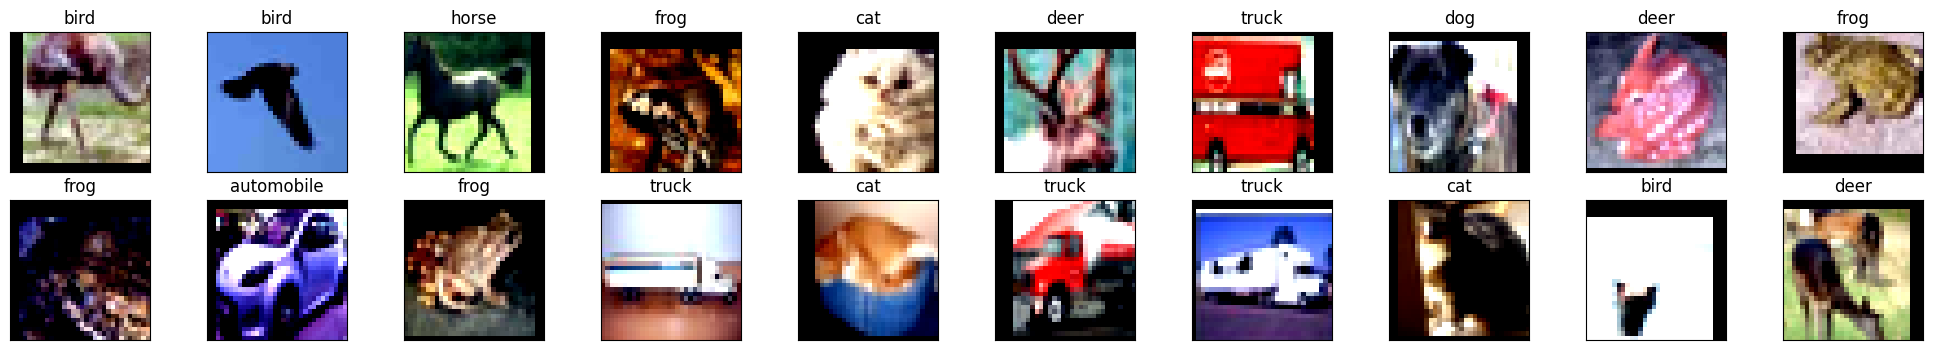

In [8]:
import matplotlib.pyplot as plt
import numpy as np
print(classes)
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
  img = img / 2 + 0.5  # unnormalize
  plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display
print(images[0].shape)
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

#**Defining the Network Architecture**
In this section the entire Research Paper is implemented to define the Residual Network approach taken by the researchers

NOTE:

Output volume for a convolutional layer
To compute the output size of a given convolutional layer we can perform the following calculation (taken from Stanford's cs231n course):

We can compute the spatial size of the output volume as a function of the input volume size (W), the kernel/filter size (F), the stride with which they are applied (S), and the amount of zero padding used (P) on the border. The correct formula for calculating how many neurons define the output_W is given by (W−F+2P)/S+1.

For example for a 7x7 input and a 3x3 filter with stride 1 and pad 0 we would get a 5x5 output. With stride 2 we would get a 3x3 output.

In [9]:
#optimizer = optim.SGD(ResNet18.parameters(), lr=learning_rate, weight_decay=0.01)
class SGDBaseOptimizer(BaseOptimizer):
  def __init__(self,model,criterion,epochs):
    super().__init__(model,criterion,epochs)
  def initialize_optimizer(self, learning_rate):
    optimizer = optim.SGD(self.model.parameters(), lr=learning_rate, weight_decay=0.0001,momentum=0.9)
    # Cosine annealing: lr → eta_min by the end
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=self.epochs,   # period (usually = total epochs)
        eta_min=0.1*learning_rate      # minimum LR (here 0.1× of 0.01)
    )
    self.optimizer,self.scheduler =  optimizer, scheduler

In [10]:
# import os
# base_model = "model/baseline.pt"
# if os.path.exists(base_model):
#     print("Load pre-trained baseline model")
# else:
#     # resnet18 = models.resnet18(weights=None, num_classes=10)   # train from scratch
#     resnet18 = ResNet18()
#     resnet18 = resnet18.to(device)
#     epochs = 100
#     criterion = nn.CrossEntropyLoss(reduction='mean')
#     learning_rate = 0.1 #from paper
#     optimizer = SGDBaseOptimizer(resnet18,criterion,epochs)
#     optimizer.initialize_optimizer(learning_rate)
#     losses_base,losses_base_val,base_acc, base_time_cost = train_once(resnet18,criterion,optimizer,train_loader,test_loader,learning_rate,epochs)
#     print("Training finished!")
#     torch.save(resnet18.state_dict(), 'model/baseline.pt')
def initialize_model(device):
    # resnet18 = models.resnet18(weights=None, num_classes=10)   # train from scratch
    resnet18 = ResNet18()
    # resnet18.load_state_dict(torch.load('baseline.pt'))
    resnet18 = resnet18.to(device)
    if device == "cuda" and torch.cuda.device_count() > 1:
        resnet18 = torch.nn.DataParallel(resnet18)
    return resnet18

#**Specifying the Loss Function and Optimizer**
We use CrossEntropyLoss as Loss function and

[Stochastic Gradient Descent](https://leon.bottou.org/publications/pdf/compstat-2010.pdf)
Adam
MuonMVR2
AdaOrth
 as Optimizer with momentum and weight decay specified by the research paper of **ON THE CONVERGENCE OF MUON AND BEYOND**

In [11]:
import torch.optim as optim
# specify loss function (categorical cross-entropy)
# specify optimizer
# optimizer = optim.SGD(ResNet18.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()


#**AdaOrthL+ method:** similar like MuonMVR2 use two random batches to decrease noise


![alt text](image.png)

In [12]:
import torch
#fix for mps
def _compile_for_device(fn):
    # Inductor doesn't support MPS; use AOTAutograd there.
    if torch.backends.mps.is_available():
        return torch.compile(fn, backend="aot_eager", dynamic=True)
    # Inductor is fine on CUDA/CPU
    return torch.compile(fn, backend="inductor", dynamic=True)

@_compile_for_device
def zeropower_via_newtonschulz5(G, steps=3, eps=1e-7):
    """
    Newton-Schulz iteration to compute the zeroth power / orthogonalization of G.
    """
    assert len(G.shape) == 2
    a, b, c = (3.4445, -4.7750,  2.0315)
    d_type = G.dtype
    X = G.bfloat16()
    #x_flat = X.reshape(-1)      # 把矩阵展平成一个 1D 向量
    X /= (X.norm() + eps) # ensure top singular value <= 1
    if G.size(0) > G.size(1):
        X = X.T
    for _ in range(steps):
        A = X @ X.T
        B = b * A + c * A @ A
        X = a * X + B @ X
    if G.size(0) > G.size(1):
        X = X.T
    return X.to(d_type)
class AdaOrth(torch.optim.Optimizer):
    def __init__(self, params, nu=1, lr=1e-3, weight_decay=0,adamw_betas=(0.95, 0.99),gamma=0.025,eps=1e-8):
        r"""
    AdaOrth: Adaptive Orthogonalized Gradient Method (Algorithm 1)

    变体：
      - nu=0  (AdaOrth-L↓):   M_t = α_t g_t + (1-α_t) M_{t-1}, g_t=∇f(X_t​;ξ_t​)
      - nu=1  (AdaOrth-L↑):   M_t​=(1−α_t​)(M_{t−1}​−∇f(X_{t-1}​;ξ_t))+∇f(X_t​;ξ_t​)

    其它：
      - α_t = ( Σ_{i=1..t} g_i^2 / max_{1..t} g_i^2 )^{-p}
      - γ_t = ( Σ_{i=1..t} m_i^2 / α_i )^{-p}
      - η_t = θ γ_t ||M_t||_F
      - X_{t+1} = X_t - η_t Orth(M_t)

    仅对二维参数（权重矩阵）使用正交化步；其它参数退化为普通 SGD。
    """
        defaults = dict(lr=lr, weight_decay=weight_decay, adamw_betas=adamw_betas, gamma=gamma, eps=eps)
        super(AdaOrth, self).__init__(params, defaults)
        self.nu = nu 
        if nu == 0:
            self.p = 0.5
        else:
            self.p = 2.0/3.0
    @torch.no_grad()
    def update_last_grad(self):
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                if "last_grad" not in state:
                    state["last_grad"] = torch.zeros_like(p)
                state["last_grad"].zero_().add_(p.grad, alpha=1.0)
    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            lr = group['lr']
            beta1, beta2 = group['adamw_betas']
            eps = group['eps']
            weight_decay = group['weight_decay']
            # momentum = group['momentum']
            gamma = group['gamma']
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['last_grad'] = torch.zeros_like(p)
                    if len(p.shape) != 2:
                        # For bias vectors - AdamW style moments
                        state['exp_avg'] = torch.zeros_like(p)
                        state['exp_avg_sq'] = torch.zeros_like(p)
                    else:
                        state['m_t'] = torch.zeros_like(p)
                        state['m_t_norm_square_div_alpha_sum'] = 0.0
                        state['g_sum'] = 0.0
                        state['g_max'] = 0.0

                last_grad = state['last_grad']
                state['step'] += 1

                if len(p.shape) == 2:
                    g_square = grad.norm().pow(2)
                    last_grad = state['last_grad']
                    state['g_sum'] += g_square
                    state['g_max'] = max(state['g_max'], g_square)
                    alpha = (state['g_sum']/(state['g_max']+eps)).pow(-self.p)
                    m_t = state['m_t']
                    if self.nu == 0:
                        m_t = (1-alpha)*m_t + alpha*grad
                    else:
                        m_t = (1-alpha)*(m_t - last_grad) + grad
                    state['m_t'] = m_t
                    m_t_norm = m_t.norm()
                    state['m_t_norm_square_div_alpha_sum'] = state['m_t_norm_square_div_alpha_sum'] + m_t_norm.pow(2)/(alpha+eps)
                    update =  zeropower_via_newtonschulz5(m_t)
                    adjusted_lr = lr*state['m_t_norm_square_div_alpha_sum'].pow(-self.p)*m_t_norm
                    p.data.mul_(1 - lr * weight_decay)
                    p.data.add_(update, alpha=-adjusted_lr)
                    if self.nu == 0:
                        state['last_grad'] = p.grad
                else:
                    # For bias vectors - use simple update
                    step = state['step']
                    # Compute momentum-like term with correction
                    c_t = (grad - last_grad).mul(gamma * (beta1 / (1. - beta1))).add(grad)
                    c_t_norm = torch.norm(c_t)
                    # avoid inductor lowering bug: compute norm explicitly and detach
                    # c_t_norm = torch.sqrt(torch.sum((c_t.detach() * c_t.detach()), dim=None))
                    if c_t_norm > 1.:
                        c_t = c_t / c_t_norm
                    exp_avg = state['exp_avg']
                    exp_avg_sq = state['exp_avg_sq']
                    exp_avg.lerp_(c_t, 1 - beta1)
                    exp_avg_sq.lerp_(c_t.square(), 1 - beta2)
                    g = exp_avg / (eps + exp_avg_sq.sqrt())
                    bias_correction1 = 1 - beta1**step
                    bias_correction2 = 1 - beta2**step
                    scale = bias_correction1 / bias_correction2**0.5
                    p.data.mul_(1 - lr * weight_decay)
                    p.data.add_(g, alpha=-lr / scale)


#**Muon-MVR2 method from ON THE CONVERGENCE OF MUON AND BEYOND**

fixed some error for mac M1

mvr2 only works with 2 dim weights, other dims use method like adam

In [13]:
'''
Muon-MVR For LLM Pretraining.
'''
import torch
import math

#fix for mps
def _compile_for_device(fn):
    # Inductor doesn't support MPS; use AOTAutograd there.
    if torch.backends.mps.is_available():
        return torch.compile(fn, backend="aot_eager", dynamic=True)
    # Inductor is fine on CUDA/CPU
    return torch.compile(fn, backend="inductor", dynamic=True)


@_compile_for_device
def zeropower_via_newtonschulz5(G, steps=3, eps=1e-7):
    """
    Newton-Schulz iteration to compute the zeroth power / orthogonalization of G.
    """
    assert len(G.shape) == 2
    a, b, c = (3.4445, -4.7750,  2.0315)
    d_type = G.dtype
    X = G.bfloat16()
    #x_flat = X.reshape(-1)      # 把矩阵展平成一个 1D 向量
    X /= (X.norm() + eps) # ensure top singular value <= 1
    if G.size(0) > G.size(1):
        X = X.T
    for _ in range(steps):
        A = X @ X.T
        B = b * A + c * A @ A
        X = a * X + B @ X
    if G.size(0) > G.size(1):
        X = X.T
    return X.to(d_type)

class MuonMVR(torch.optim.Optimizer):
    r'''
    Standard MVR:\\(nabla f(X_t;\xi_t) - \\nabla f(X_{t-1};\xi_{t})
    Approximate MVR:
        1.\\(nabla f(X_t;\xi_t) - \\nabla f(X_{t-1};\xi_{t-1})
        2.\\(nabla f(X_t;\xi_t) - \\nabla f(X_{t};\xi_{t-1}), It has low computational complexity
         and is more convenient in practice
    '''
    def __init__(self, params, lr=3e-3, momentum = 0.95 ,adamw_betas=(0.95, 0.99), eps=1e-8,
                 weight_decay=0.0, gamma=0.025, is_approx=False):
        if lr < 0.0:
            raise ValueError(f"Invalid learning rate: {lr}")
        if not 0.0 <= momentum < 1.0:
            raise ValueError(f"Invalid momentum parameter: {momentum}")
        if not 0.0 <= adamw_betas[0] < 1.0:
            raise ValueError(f"Invalid beta1 parameter: {adamw_betas[0]}")
        if not 0.0 <= adamw_betas[1] < 1.0:
            raise ValueError(f"Invalid beta2 parameter: {adamw_betas[1]}")

        defaults = dict(lr=lr, momentum=momentum,adamw_betas=adamw_betas, eps=eps,
                       weight_decay=weight_decay, gamma=gamma)
        super().__init__(params, defaults)
        self.is_approx = is_approx

    def adjust_lr_for_muon(self, lr, param_shape):
        A, B = param_shape[:2]
        # We adjust the learning rate and weight decay based on the size of the parameter matrix
        # as describted in the paper
        adjusted_ratio = 0.2 * math.sqrt(max(A, B))
        # adjusted_ratio = math.sqrt(A*B)
        adjusted_lr = lr * adjusted_ratio
        return adjusted_lr

    @torch.no_grad()
    def update_last_grad(self):
        if not self.is_approx:
            for group in self.param_groups:
                for p in group['params']:
                    state = self.state[p]
                    if "last_grad" not in state:
                        state["last_grad"] = torch.zeros_like(p)
                    state["last_grad"].zero_().add_(p.grad, alpha=1.0)

    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            lr = group['lr']
            beta1, beta2 = group['adamw_betas']
            eps = group['eps']
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            gamma = group['gamma']

            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p)
                    state['last_grad'] = torch.zeros_like(p)
                    # state['previous_grad'] = torch.zeros_like(p)
                    if len(p.shape) != 2:  # Only for 2D tensors
                        state['exp_avg_sq'] = torch.zeros_like(p)

                state['step'] += 1
                last_grad = state['last_grad']
                if len(p.shape) == 2:
                    exp_avg = state['exp_avg']

                    # Compute momentum-like term with correction
                    c_t = (grad - last_grad).mul(gamma * (momentum / (1. - momentum))).add(grad)
                    c_t_norm = torch.norm(c_t)
                    if c_t_norm > 1.:
                        c_t = c_t / c_t_norm
                    # Update moving averages
                    exp_avg.mul_(momentum).add_(c_t, alpha=1 - momentum)
                    update = zeropower_via_newtonschulz5(exp_avg.mul(1./(1.- momentum))) # whiten the update
                    adjusted_lr = self.adjust_lr_for_muon(lr, p.shape)
                    p.data.mul_(1 - lr * weight_decay)
                    p.data.add_(update, alpha=-adjusted_lr)
                else:
                    # For bias vectors - use simple update
                    step = state['step']
                    # Compute momentum-like term with correction
                    c_t = (grad - last_grad).mul(gamma * (beta1 / (1. - beta1))).add(grad)
                    c_t_norm = torch.norm(c_t)
                    # avoid inductor lowering bug: compute norm explicitly and detach
                    # c_t_norm = torch.sqrt(torch.sum((c_t.detach() * c_t.detach()), dim=None))
                    if c_t_norm > 1.:
                        c_t = c_t / c_t_norm
                    exp_avg = state['exp_avg']
                    exp_avg_sq = state['exp_avg_sq']
                    exp_avg.lerp_(c_t, 1 - beta1)
                    exp_avg_sq.lerp_(c_t.square(), 1 - beta2)
                    g = exp_avg / (eps + exp_avg_sq.sqrt())
                    bias_correction1 = 1 - beta1**step
                    bias_correction2 = 1 - beta2**step
                    scale = bias_correction1 / bias_correction2**0.5
                    p.data.mul_(1 - lr * weight_decay)
                    p.data.add_(g, alpha=-lr / scale)

                if self.is_approx:
                    state['last_grad'].copy_(grad)

#**MuonMVR Training Loop**
Here we train the architecture on training data and check its validation loss by using the validation set and saving the model only if there is an improvement ie decrease in the validation loss.

## MVR2 Usage
3.  **Optimizer Modes**
    MuonMVR can be initialized in different modes to trade off between precision and computational cost.

    **Exact Variance Reduction (`is_approx=False`)**
    To achieve the most precise variance reduction, you must manually manage the model state. Before calculating the gradient for the previous batch, you need to load the model state from the previous iteration. This ensures that the gradient is computed with the correct model weights.
    ```python
    optimizer = MuonMVR(model.parameters(), lr=1e-3, is_approx=False)
    old_state_dict = {}
    
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        # Store the current model state
        cur_state_dict = {k: v.data.clone() for k, v in net.state_dict().items()}
    
        if old_state_dict:
            # Load the previous model state to compute the old gradient
            net.load_state_dict(old_state_dict)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.update_last_grad()
    
        # Restore the current model state to compute the new gradient
        net.load_state_dict(cur_state_dict)
        old_state_dict = {k: v.data.clone() for k, v in cur_state_dict.items()}
        
        # Standard forward/backward pass and step
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    ```

In [14]:
class MuonMVR2Optimizer(BaseOptimizer):
  def __init__(self,model,criterion,epochs):
    super().__init__(model,criterion,epochs)
    self.old_state_dict = {}
  def initialize_optimizer(self, learning_rate):
    optimizer = MuonMVR(self.model.parameters(), lr=learning_rate,weight_decay=0.01,gamma=0.1,is_approx=False)
    # Cosine annealing: lr → eta_min by the end
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=self.epochs,   # period (usually = total epochs)
        eta_min=0.1*learning_rate      # minimum LR (here 0.1× of 0.01)
    )
    self.optimizer,self.scheduler =  optimizer, scheduler
  def zero_grad(self,inputs=None,labels=None):
    model, old_state_dict = self.model, self.old_state_dict
    optimizer = self.optimizer
    # Store the current model state
    cur_state_dict = {k: v.data.clone() for k, v in model.state_dict().items()}
    if old_state_dict:
        # Load the previous model state to compute the old gradient
        model.load_state_dict(old_state_dict)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.update_last_grad()
    #restore state
    model.load_state_dict(cur_state_dict)
    self.old_state_dict = {k: v.data.clone() for k, v in cur_state_dict.items()}
    self.optimizer.zero_grad()

In [15]:
epochs = 100

##**grid search learning rate for MuonMVR2**

In [16]:
learning_rates = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
def grids_search_val(get_optimizer):
  result = []
  for ii, learning_rate in enumerate(learning_rates):
    print(f".........Learning rate {ii+1}/{len(learning_rates)}: {learning_rate}............")
    model = initialize_model(device)
    optimizer = get_optimizer(model, learning_rate)
    train_losses, val_losses, acc, time_cost = train_once(model,criterion,optimizer,train_loader,val_loader,learning_rate,epochs)
    result.append(min(val_losses))
  return result



In [ ]:
def muonmvr2_optimizer(model,learning_rate):
  optimizer = MuonMVR2Optimizer(model,criterion,epochs)
  optimizer.initialize_optimizer(learning_rate)
  return optimizer
#4242
#on val
result_mvr2 = [0.42282930165529253, 0.3560429185628891, 0.33734901435673237, 
               0.3331120379269123, 0.36680362820625306, 0.36583446301519873, 0.34629936777055265]
if not result_mvr2:
  result_mvr2 = grids_search_val(muonmvr2_optimizer)
  #result = [x.cpu() for x in result]
print(result_mvr2)


[0.42282930165529253, 0.3560429185628891, 0.33734901435673237, 0.3331120379269123, 0.36680362820625306, 0.36583446301519873, 0.34629936777055265]


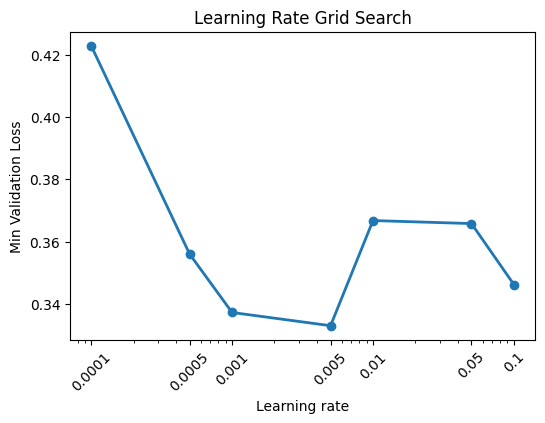

In [ ]:
plt.figure(figsize=(6,4))
plt.xscale('log')   # good practice for learning rates
plt.xlabel("Learning rate")
plt.ylabel("Min Validation Loss")
plt.title("Learning Rate Grid Search")
plt.xticks(learning_rates, labels=[str(lr) for lr in learning_rates],rotation=45)
plt.plot(learning_rates, result_mvr2, label="Grid Search(Validataion Loss)", linewidth=2, marker='o')

In [19]:
min_index = result_mvr2.index(min(result_mvr2))
learning_rate = learning_rates[min_index]
print(f"Best learning rate: {learning_rate}, Min val loss: {result_mvr2[min_index]}")

Best learning rate: 0.005, Min val loss: 0.3331120379269123


In [20]:
# import torch
# torch._dynamo.config.verbose = True
# import os
# os.environ["TORCH_LOGS"] = "recompiles,graph_breaks,guards"

#**training Model with MuonMVR2 using best learning rate**


In [21]:
# learning_rate = 0.05 #from paper
model_mvr2 = initialize_model(device)
optimizer = muonmvr2_optimizer(model_mvr2, learning_rate)
losses_mvr2,losses_mvr2_val, mvr2_acc, mvr2_time_cost = train_once(model_mvr2,criterion,optimizer,train_loader,test_loader,learning_rate,epochs)

Test Loss: 1.394366

Test Accuracy of airplane: 37% (372/1000)
Test Accuracy of automobile: 34% (342/1000)
Test Accuracy of  bird: 40% (404/1000)
Test Accuracy of   cat: 24% (244/1000)
Test Accuracy of  deer: 33% (334/1000)
Test Accuracy of   dog: 45% (455/1000)
Test Accuracy of  frog: 64% (641/1000)
Test Accuracy of horse: 72% (725/1000)
Test Accuracy of  ship: 79% (793/1000)
Test Accuracy of truck: 80% (806/1000)

Test Accuracy (Overall): 51% (5116/10000)
[1] time: 19.468207597732544 loss: 1.543 val_loss:1.394365531206131 current_lr=0.004999
Test Loss: 1.063132

Test Accuracy of airplane: 75% (757/1000)
Test Accuracy of automobile: 80% (800/1000)
Test Accuracy of  bird: 63% (635/1000)
Test Accuracy of   cat: 51% (511/1000)
Test Accuracy of  deer: 50% (506/1000)
Test Accuracy of   dog: 51% (512/1000)
Test Accuracy of  frog: 80% (808/1000)
Test Accuracy of horse: 65% (654/1000)
Test Accuracy of  ship: 45% (453/1000)
Test Accuracy of truck: 66% (665/1000)

Test Accuracy (Overall): 63% (

#**SGD learning rate search**

In [22]:
#optimizer = optim.SGD(ResNet18.parameters(), lr=learning_rate, weight_decay=0.01)
class SGDOptimizer(BaseOptimizer):
  def __init__(self,model,criterion,epochs):
    super().__init__(model,criterion,epochs)
  def initialize_optimizer(self, learning_rate):
    optimizer = optim.SGD(self.model.parameters(), lr=learning_rate, weight_decay=0.01)
    # Cosine annealing: lr → eta_min by the end
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=self.epochs,   # period (usually = total epochs)
        eta_min=0.1*learning_rate      # minimum LR (here 0.1× of 0.01)
    )
    self.optimizer,self.scheduler =  optimizer, scheduler

.........Learning rate 1/7: 0.0001............


Test Loss: 2.279715

Test Accuracy of airplane: 28% (282/1000)
Test Accuracy of automobile:  1% (13/1000)
Test Accuracy of  bird:  0% (0/1000)
Test Accuracy of   cat: 89% (896/1000)
Test Accuracy of  deer:  0% (1/1000)
Test Accuracy of   dog:  0% (0/1000)
Test Accuracy of  frog:  0% (1/1000)
Test Accuracy of horse:  0% (0/1000)
Test Accuracy of  ship:  0% (8/1000)
Test Accuracy of truck: 12% (129/1000)

Test Accuracy (Overall): 13% (1330/10000)
[1] time: 10.452178478240967 loss: 2.343 val_loss:2.2797154009342195 current_lr=0.000100
Test Loss: 2.219428

Test Accuracy of airplane: 48% (485/1000)
Test Accuracy of automobile:  6% (66/1000)
Test Accuracy of  bird:  0% (8/1000)
Test Accuracy of   cat: 64% (646/1000)
Test Accuracy of  deer: 13% (136/1000)
Test Accuracy of   dog:  0% (9/1000)
Test Accuracy of  frog:  4% (49/1000)
Test Accuracy of horse:  0% (8/1000)
Test Accuracy of  ship: 11% (118/1000)
Test Accuracy of truck: 17% (170/1000)

Test Accuracy (Overall): 16% (1695/10000)
[2] time

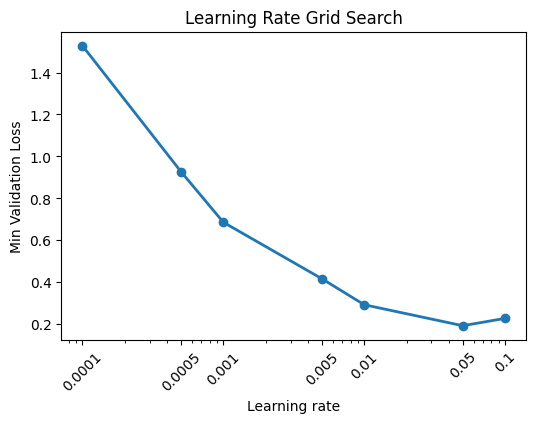

In [23]:
def get_sgd(model, learning_rate):
    optimizer = SGDOptimizer(model, criterion, epochs)
    optimizer.initialize_optimizer(learning_rate)
    return optimizer
result_sgd = []
if not result_sgd:
    result_sgd = grids_search_val(get_sgd)
    #result_sgd = [float(x.cpu()) for x in result_sgd]
print(result_sgd)
min_index = result_sgd.index(min(result_sgd))
learning_rate = learning_rates[min_index]
print(f"Best learning rate: {learning_rate}, Min val loss: {result_sgd[min_index]}")
plt.figure(figsize=(6,4))
plt.xscale('log')   # good practice for learning rates
plt.xlabel("Learning rate")
plt.ylabel("Min Validation Loss")
plt.title("Learning Rate Grid Search")
plt.xticks(learning_rates, labels=[str(lr) for lr in learning_rates],rotation=45)
plt.plot(learning_rates, result_sgd, label="Grid Search(Validataion Loss)", linewidth=2, marker='o')

#**SGD Training Model with best learning rate**

In [24]:
# learning_rate = 0.1 #from paper
model_sgd = initialize_model(device)
optimizer = SGDOptimizer(model_sgd,criterion,epochs)
optimizer.initialize_optimizer(learning_rate)
losses_sgd,losses_sgd_val,sgd_acc, sgd_time_cost = train_once(model_sgd,criterion,optimizer,train_loader,test_loader,learning_rate,epochs)
print("Training finished!")

Test Loss: 2.353680

Test Accuracy of airplane: 23% (233/1000)
Test Accuracy of automobile: 11% (119/1000)
Test Accuracy of  bird: 38% (386/1000)
Test Accuracy of   cat:  0% (6/1000)
Test Accuracy of  deer: 59% (595/1000)
Test Accuracy of   dog: 28% (280/1000)
Test Accuracy of  frog: 82% (829/1000)
Test Accuracy of horse:  1% (17/1000)
Test Accuracy of  ship: 31% (317/1000)
Test Accuracy of truck: 21% (214/1000)

Test Accuracy (Overall): 29% (2996/10000)
[1] time: 10.599814891815186 loss: 1.655 val_loss:2.3536803662776946 current_lr=0.049989
Test Loss: 1.534422

Test Accuracy of airplane: 40% (407/1000)
Test Accuracy of automobile: 98% (984/1000)
Test Accuracy of  bird: 68% (686/1000)
Test Accuracy of   cat: 18% (186/1000)
Test Accuracy of  deer: 37% (374/1000)
Test Accuracy of   dog: 51% (515/1000)
Test Accuracy of  frog: 63% (635/1000)
Test Accuracy of horse: 57% (575/1000)
Test Accuracy of  ship: 36% (368/1000)
Test Accuracy of truck: 36% (365/1000)

Test Accuracy (Overall): 50% (50

#**Adam Optimizer Learning Rate Search**

In [25]:
class AdamOptimizer(BaseOptimizer):
  def __init__(self,model,criterion,epochs):
    super().__init__(model,criterion,epochs)
  def initialize_optimizer(self, learning_rate):
    optimizer = optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=0.01)
    # Cosine annealing: lr → eta_min by the end
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=self.epochs,   # period (usually = total epochs)
        eta_min=0.1*learning_rate      # minimum LR (here 0.1× of 0.01)
    )
    self.optimizer,self.scheduler =  optimizer, scheduler

.........Learning rate 1/7: 0.0001............
Test Loss: 1.245503

Test Accuracy of airplane: 79% (799/1000)
Test Accuracy of automobile: 71% (713/1000)
Test Accuracy of  bird: 54% (541/1000)
Test Accuracy of   cat: 33% (331/1000)
Test Accuracy of  deer: 31% (314/1000)
Test Accuracy of   dog: 53% (534/1000)
Test Accuracy of  frog: 70% (703/1000)
Test Accuracy of horse: 40% (409/1000)
Test Accuracy of  ship: 63% (639/1000)
Test Accuracy of truck: 50% (507/1000)

Test Accuracy (Overall): 54% (5490/10000)
[1] time: 10.676311731338501 loss: 1.457 val_loss:1.245503167808056 current_lr=0.000100
Test Loss: 1.019154

Test Accuracy of airplane: 78% (785/1000)
Test Accuracy of automobile: 68% (683/1000)
Test Accuracy of  bird: 60% (609/1000)
Test Accuracy of   cat: 47% (475/1000)
Test Accuracy of  deer: 57% (575/1000)
Test Accuracy of   dog: 30% (309/1000)
Test Accuracy of  frog: 85% (855/1000)
Test Accuracy of horse: 65% (652/1000)
Test Accuracy of  ship: 72% (722/1000)
Test Accuracy of truck:

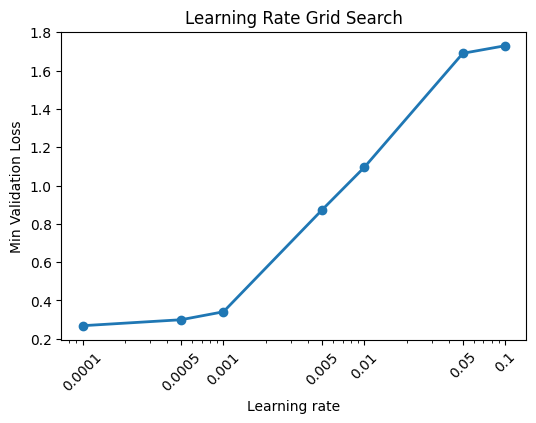

In [ ]:
def get_adam(model, learning_rate):
    optimizer = AdamOptimizer(model, criterion, epochs)
    optimizer.initialize_optimizer(learning_rate)
    return optimizer
result_adam = [0.26834110654890536, 0.29946966730058194, 0.3410443864762783, 
               0.8723099827766418, 1.0954962521791458, 1.6904775649309158, 1.7301369339227677]

if not result_adam:
    result_adam = grids_search_val(get_adam)
print(result_adam)
min_index = result_adam.index(min(result_adam))
learning_rate = learning_rates[min_index]
print(f"Best learning rate: {learning_rate}, Min val loss: {result_adam[min_index]}")
plt.figure(figsize=(6,4))
plt.xscale('log')   # good practice for learning rates
plt.xlabel("Learning rate")
plt.ylabel("Min Validation Loss")
plt.title("Learning Rate Grid Search")
plt.xticks(learning_rates, labels=[str(lr) for lr in learning_rates],rotation=45)
plt.plot(learning_rates, result_adam, label="Grid Search(Validataion Loss)", linewidth=2, marker='o')

#**Adam Training with best learning rate**

In [ ]:
# learning_rate = 0.01
model_adam = initialize_model(device)
optimizer = AdamOptimizer(model_adam,criterion,epochs)
optimizer.initialize_optimizer(learning_rate)
losses_adam,losses_adam_val, adam_acc ,adam_time_cost = train_once(model_adam,criterion,optimizer,train_loader,test_loader,learning_rate,epochs)
print("Training finished!")                  

Test Loss: 1.286661

Test Accuracy of airplane: 68% (683/1000)
Test Accuracy of automobile: 91% (911/1000)
Test Accuracy of  bird: 58% (581/1000)
Test Accuracy of   cat: 17% (175/1000)
Test Accuracy of  deer: 58% (582/1000)
Test Accuracy of   dog: 45% (454/1000)
Test Accuracy of  frog: 59% (593/1000)
Test Accuracy of horse: 62% (623/1000)
Test Accuracy of  ship: 46% (462/1000)
Test Accuracy of truck: 32% (322/1000)

Test Accuracy (Overall): 53% (5386/10000)
[1] time: 10.398508787155151 loss: 1.431 val_loss:1.2866609275341034 current_lr=0.000100
Test Loss: 0.962052

Test Accuracy of airplane: 62% (620/1000)
Test Accuracy of automobile: 91% (918/1000)
Test Accuracy of  bird: 57% (572/1000)
Test Accuracy of   cat: 50% (504/1000)
Test Accuracy of  deer: 60% (604/1000)
Test Accuracy of   dog: 67% (678/1000)
Test Accuracy of  frog: 69% (695/1000)
Test Accuracy of horse: 58% (585/1000)
Test Accuracy of  ship: 82% (828/1000)
Test Accuracy of truck: 56% (569/1000)

Test Accuracy (Overall): 65% 

In [28]:
class AdaOrthOptimizer(BaseOptimizer):
  def __init__(self,model,criterion,epochs):
    super().__init__(model,criterion,epochs)
    self.old_state_dict = {}
  def initialize_optimizer(self, learning_rate):
    optimizer = AdaOrth(self.model.parameters(),nu=1, lr=learning_rate, weight_decay=0.01,gamma=0.1)
    # Cosine annealing: lr → eta_min by the end
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=self.epochs,   # period (usually = total epochs)
        eta_min=0.1*learning_rate      # minimum LR (here 0.1× of 0.01)
    )
    self.optimizer,self.scheduler =  optimizer, scheduler
  def zero_grad(self,inputs=None,labels=None):
    model, old_state_dict = self.model, self.old_state_dict
    optimizer = self.optimizer
    # Store the current model state
    cur_state_dict = {k: v.data.clone() for k, v in model.state_dict().items()}
    if self.old_state_dict:
        # Load the previous model state to compute the old gradient
        model.load_state_dict(old_state_dict)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.update_last_grad()
    #restore state
    model.load_state_dict(cur_state_dict)
    self.old_state_dict = {k: v.data.clone() for k, v in cur_state_dict.items()}
    self.optimizer.zero_grad()

#**AdaOrth Learning Rate Search**

.........Learning rate 1/7: 0.0001............
Test Loss: 1.177532

Test Accuracy of airplane: 52% (520/1000)
Test Accuracy of automobile: 71% (717/1000)
Test Accuracy of  bird: 42% (423/1000)
Test Accuracy of   cat: 34% (340/1000)
Test Accuracy of  deer: 40% (400/1000)
Test Accuracy of   dog: 65% (655/1000)
Test Accuracy of  frog: 70% (708/1000)
Test Accuracy of horse: 59% (594/1000)
Test Accuracy of  ship: 78% (781/1000)
Test Accuracy of truck: 66% (664/1000)

Test Accuracy (Overall): 58% (5802/10000)
[1] time: 23.7699978351593 loss: 1.473 val_loss:1.1775323539972304 current_lr=0.000100
Test Loss: 0.965670

Test Accuracy of airplane: 71% (717/1000)
Test Accuracy of automobile: 80% (801/1000)
Test Accuracy of  bird: 56% (564/1000)
Test Accuracy of   cat: 29% (293/1000)
Test Accuracy of  deer: 57% (576/1000)
Test Accuracy of   dog: 66% (665/1000)
Test Accuracy of  frog: 76% (765/1000)
Test Accuracy of horse: 75% (755/1000)
Test Accuracy of  ship: 76% (769/1000)
Test Accuracy of truck: 

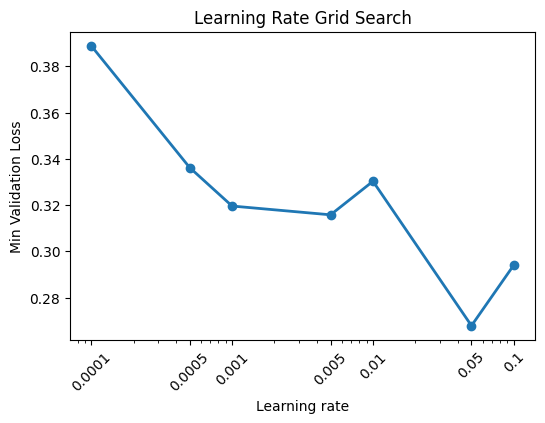

In [ ]:
def get_adaorth(model, learning_rate):
    optimizer = AdaOrthOptimizer(model, criterion, epochs)
    optimizer.initialize_optimizer(learning_rate)
    return optimizer
#42
#4242
#on val loader
result_adaorth = [0.3888972084969282, 0.3362036179751158, 0.31956511475145816, 
0.3157649368047714, 0.33026970345526935, 0.26781179793179033, 0.29409450609236953]

if not result_adaorth:
    result_adaorth = grids_search_val(get_adaorth)
    #result_adaorth = [float(x.cpu()) for x in result_adaorth]
print(result_adaorth)
min_index = result_adaorth.index(min(result_adaorth))
learning_rate = learning_rates[min_index]
print(f"Best learning rate: {learning_rate}, Min val loss: {result_adaorth[min_index]}")
plt.figure(figsize=(6,4))
plt.xscale('log')   # good practice for learning rates
plt.xlabel("Learning rate")
plt.ylabel("Min Validation Loss")
plt.title("Learning Rate Grid Search")
plt.xticks(learning_rates, labels=[str(lr) for lr in learning_rates],rotation=45)
plt.plot(learning_rates, result_adaorth, label="Grid Search(Validataion Loss)", linewidth=2, marker='o')

#**AdaOrth Training with best learning rate**

In [30]:
model_adaorth = initialize_model(device)
optimizer = AdaOrthOptimizer(model_adaorth,criterion,epochs)
optimizer.initialize_optimizer(learning_rate)
losses_adaorth,losses_adaorth_val, adaorth_acc ,adaorth_time_cost = train_once(model_adaorth,criterion,optimizer,train_loader,test_loader,learning_rate,epochs)
print("Training finished!")

Test Loss: 1.579874

Test Accuracy of airplane: 54% (541/1000)
Test Accuracy of automobile: 49% (491/1000)
Test Accuracy of  bird: 58% (583/1000)
Test Accuracy of   cat: 27% (272/1000)
Test Accuracy of  deer: 13% (133/1000)
Test Accuracy of   dog: 46% (464/1000)
Test Accuracy of  frog: 25% (251/1000)
Test Accuracy of horse: 28% (288/1000)
Test Accuracy of  ship: 73% (737/1000)
Test Accuracy of truck: 48% (481/1000)

Test Accuracy (Overall): 42% (4241/10000)
[1] time: 23.225728273391724 loss: 1.720 val_loss:1.5798741906881333 current_lr=0.049989
Test Loss: 1.164304

Test Accuracy of airplane: 68% (684/1000)
Test Accuracy of automobile: 86% (865/1000)
Test Accuracy of  bird: 58% (580/1000)
Test Accuracy of   cat: 40% (401/1000)
Test Accuracy of  deer: 41% (415/1000)
Test Accuracy of   dog: 57% (572/1000)
Test Accuracy of  frog: 41% (415/1000)
Test Accuracy of horse: 72% (723/1000)
Test Accuracy of  ship: 67% (679/1000)
Test Accuracy of truck: 56% (562/1000)

Test Accuracy (Overall): 58% 

In [31]:
class AdaOrthLMinusOptimizer(BaseOptimizer):
  def __init__(self,model,criterion,epochs):
    super().__init__(model,criterion,epochs)
  def initialize_optimizer(self, learning_rate):
    #weight_decay=0.01,gamma=0.1
    optimizer = AdaOrth(self.model.parameters(),nu=0, lr=learning_rate, weight_decay=0.01,gamma=0.1)
    # Cosine annealing: lr → eta_min by the end
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=self.epochs,   # period (usually = total epochs)
        eta_min=0.1*learning_rate      # minimum LR (here 0.1× of 0.01)
    )
    self.optimizer,self.scheduler =  optimizer, scheduler

.........Learning rate 1/7: 0.0001............
Test Loss: 1.265526

Test Accuracy of airplane: 50% (509/1000)
Test Accuracy of automobile: 66% (662/1000)
Test Accuracy of  bird: 38% (386/1000)
Test Accuracy of   cat: 33% (339/1000)
Test Accuracy of  deer: 50% (501/1000)
Test Accuracy of   dog: 55% (555/1000)
Test Accuracy of  frog: 66% (660/1000)
Test Accuracy of horse: 45% (459/1000)
Test Accuracy of  ship: 65% (651/1000)
Test Accuracy of truck: 82% (821/1000)

Test Accuracy (Overall): 55% (5543/10000)
[1] time: 13.989864826202393 loss: 1.468 val_loss:1.2655261605978012 current_lr=0.000100
Test Loss: 1.036897

Test Accuracy of airplane: 74% (740/1000)
Test Accuracy of automobile: 92% (926/1000)
Test Accuracy of  bird: 55% (558/1000)
Test Accuracy of   cat: 54% (549/1000)
Test Accuracy of  deer: 38% (386/1000)
Test Accuracy of   dog: 50% (504/1000)
Test Accuracy of  frog: 76% (760/1000)
Test Accuracy of horse: 62% (627/1000)
Test Accuracy of  ship: 72% (726/1000)
Test Accuracy of truck

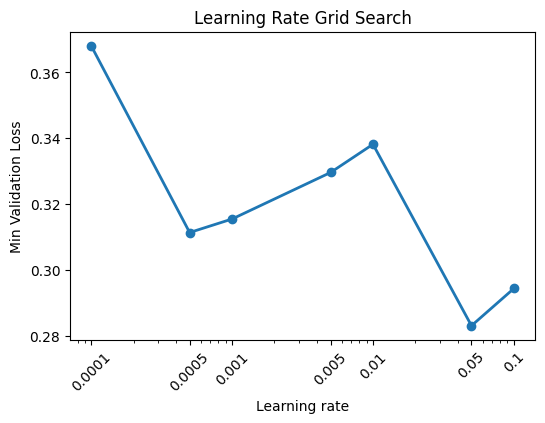

In [ ]:
def get_adaorthlminus(model, learning_rate):
    optimizer = AdaOrthLMinusOptimizer(model, criterion, epochs)
    optimizer.initialize_optimizer(learning_rate)
    return optimizer
#42
#4242
result_adaorthlminus = [0.368110310472548, 0.3114191148430109, 0.3155186824500561, 
                        0.32963236048817635, 0.33819711543619635, 0.28313865754753353, 0.29443599469959736]

if not result_adaorthlminus:
    result_adaorthlminus = grids_search_val(get_adaorthlminus)
print(result_adaorthlminus)
min_index = result_adaorthlminus.index(min(result_adaorthlminus))
learning_rate = learning_rates[min_index]
print(f"Best learning rate: {learning_rate}, Min val loss: {result_adaorthlminus[min_index]}")
plt.figure(figsize=(6,4))
plt.xscale('log')   # good practice for learning rates
plt.xlabel("Learning rate")
plt.ylabel("Min Validation Loss")
plt.title("Learning Rate Grid Search")
plt.xticks(learning_rates, labels=[str(lr) for lr in learning_rates],rotation=45)
plt.plot(learning_rates, result_adaorthlminus, label="Grid Search(Validataion Loss)", linewidth=2, marker='o')

In [33]:
model_adaorthlminus = initialize_model(device)
optimizer = AdaOrthLMinusOptimizer(model_adaorthlminus,criterion,epochs)
optimizer.initialize_optimizer(learning_rate)
losses_adaorthlminus,losses_adaorthlminus_val, \
adaorthlminus_acc ,adaorthlminus_time_cost = \
train_once(model_adaorthlminus,criterion,optimizer,train_loader,test_loader,learning_rate,epochs)
print("Training finished!")

Test Loss: 1.730180

Test Accuracy of airplane: 42% (423/1000)
Test Accuracy of automobile: 51% (512/1000)
Test Accuracy of  bird: 32% (321/1000)
Test Accuracy of   cat:  8% (80/1000)
Test Accuracy of  deer:  3% (30/1000)
Test Accuracy of   dog: 24% (248/1000)
Test Accuracy of  frog: 78% (783/1000)
Test Accuracy of horse: 30% (303/1000)
Test Accuracy of  ship: 45% (458/1000)
Test Accuracy of truck: 70% (708/1000)

Test Accuracy (Overall): 38% (3866/10000)
[1] time: 14.019332885742188 loss: 1.852 val_loss:1.7301798194646836 current_lr=0.049989
Test Loss: 1.284022

Test Accuracy of airplane: 67% (676/1000)
Test Accuracy of automobile: 75% (755/1000)
Test Accuracy of  bird: 23% (239/1000)
Test Accuracy of   cat: 24% (244/1000)
Test Accuracy of  deer: 44% (441/1000)
Test Accuracy of   dog: 55% (551/1000)
Test Accuracy of  frog: 69% (697/1000)
Test Accuracy of horse: 63% (636/1000)
Test Accuracy of  ship: 46% (468/1000)
Test Accuracy of truck: 65% (657/1000)

Test Accuracy (Overall): 53% (5

#**Plot Training Loss and Val Loss**

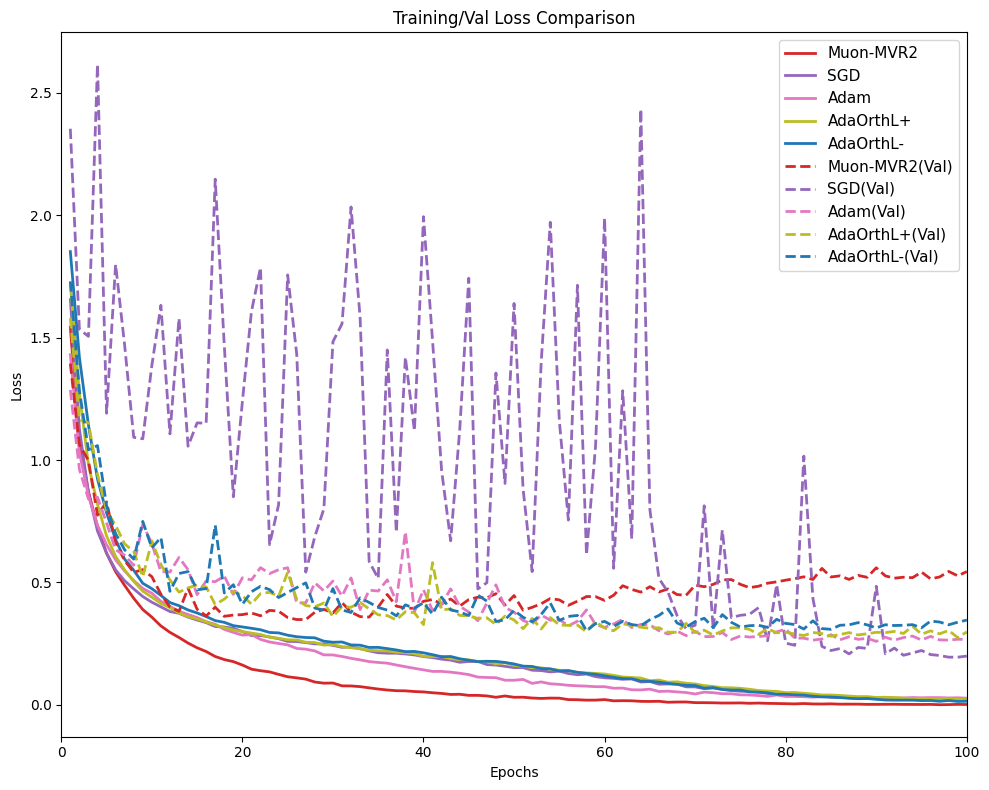

In [34]:
plt.figure(figsize=(10,8))
epochs_range = range(1, epochs + 1)
# 定义每个算法的颜色（可自定义）
# colors = {
#     "mvr2": "#1f77b4",     # 蓝色
#     "sgd": "#2ca02c",      # 绿色
#     "adamw": "#d62728",    # 红色
#     "adaorth": "#9467bd",  # 紫色
# }
colors = {
    # 🔴 Bright red — strong attention color; highlights the best or main method
    "Muon-MVR2": "#d62728",

    # 🟠 Orange — warm tone; second-best or related variant of the main method
    "Muon-MVR1": "#ff7f0e",

    # 🟢 Green/Teal — balanced, calm color; used for the γ=0 ablation variant
    "Muon-MVR1 (γ=0)": "#2ca02c",

    # 🌸 Pink — soft complementary tone; represents Adam (adaptive optimizer family)
    "Adam": "#e377c2",

    # 🟣 Purple — cool, classic hue; represents SGD (baseline optimizer)
    "SGD": "#9467bd",

    # 🔵 Deep blue — reliable, professional color; for AdaOrth-L (new proposed variant)
    "AdaOrthL-": "#1f77b4",

    # 🟡 Olive-yellow — contrasting, bright accent; for AdaOrth-AL+ (advanced/larger version)
    "AdaOrthL+": "#bcbd22",
}


plt.plot(epochs_range, losses_mvr2, label="Muon-MVR2", linewidth=2, color=colors["Muon-MVR2"])
plt.plot(epochs_range, losses_sgd, label="SGD", linewidth=2,color=colors["SGD"])
plt.plot(epochs_range, losses_adam, label="Adam", linewidth=2,color=colors["Adam"])
plt.plot(epochs_range, losses_adaorth, label="AdaOrthL+", linewidth=2,color=colors["AdaOrthL+"])
plt.plot(epochs_range, losses_adaorthlminus, label="AdaOrthL-", linewidth=2,color=colors["AdaOrthL-"])

plt.plot(epochs_range ,losses_mvr2_val, label="Muon-MVR2(Val)", linewidth=2, linestyle='--',color=colors["Muon-MVR2"])
plt.plot(epochs_range, losses_sgd_val, label="SGD(Val)", linewidth=2, linestyle='--',color=colors["SGD"])
plt.plot(epochs_range, losses_adam_val, label="Adam(Val)", linewidth=2, linestyle='--',color=colors["Adam"])
plt.plot(epochs_range, losses_adaorth_val, label="AdaOrthL+(Val)", linewidth=2, linestyle='--',color=colors["AdaOrthL+"])
plt.plot(epochs_range, losses_adaorthlminus_val, label="AdaOrthL-(Val)", linewidth=2, linestyle='--',color=colors["AdaOrthL-"])

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training/Val Loss Comparison")
plt.legend(fontsize=11, frameon=True)
plt.xlim(0, len(epochs_range))
plt.tight_layout()

#**Plot Validation Accuracy**

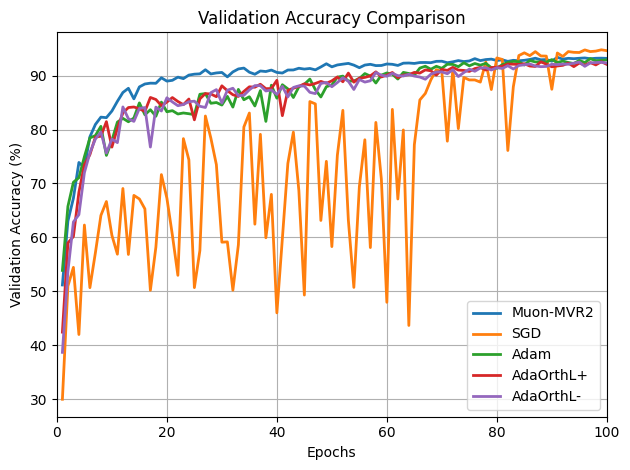

In [35]:
# plt.figure(figsize=(10,6))
epochs_range = range(1, epochs + 1)
plt.plot(epochs_range, mvr2_acc, label="Muon-MVR2", linewidth=2)
plt.plot(epochs_range, sgd_acc, label="SGD", linewidth=2)
plt.plot(epochs_range, adam_acc, label="Adam", linewidth=2)
plt.plot(epochs_range, adaorth_acc, label="AdaOrthL+", linewidth=2)
plt.plot(epochs_range, adaorthlminus_acc, label="AdaOrthL-", linewidth=2)

plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy Comparison")
plt.grid(True)
plt.legend()
plt.xlim(0, len(epochs_range))
plt.tight_layout()
plt.show()

#**Plot Validation Accuracy with Wall Clock Time**

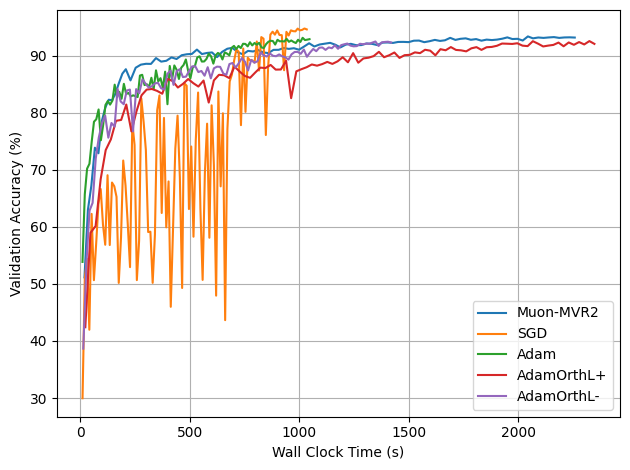

In [36]:
import matplotlib.pyplot as plt
plt.plot(mvr2_time_cost, mvr2_acc, label = "Muon-MVR2")
plt.plot(sgd_time_cost, sgd_acc, label="SGD")
plt.plot(adam_time_cost, adam_acc, label="Adam")
plt.plot(adaorth_time_cost, adaorth_acc, label="AdamOrthL+")
plt.plot(adaorthlminus_time_cost, adaorthlminus_acc, label="AdamOrthL-")

plt.xlabel("Wall Clock Time (s)")
plt.ylabel("Validation Accuracy (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
print(max(mvr2_acc), max(sgd_acc), max(adam_acc), max(adaorth_acc), max(adaorthlminus_acc))

93.4 94.79 93.16 92.58 92.51


In [45]:
save_path = "./results/"
import os
if not os.path.exists(save_path):
    os.makedirs(save_path)
import pickle
with open(save_path+"result_mvr2.pkl", "wb") as f:
    pickle.dump({
        "losses": losses_mvr2,
        "val_losses": losses_mvr2_val,
        "acc": mvr2_acc,
        "time_cost": mvr2_time_cost,
        "result_grid_search": result_mvr2
    }, f)
with open(save_path+"result_sgd.pkl", "wb") as f:
    pickle.dump({
        "losses": losses_sgd,
        "val_losses": losses_sgd_val,
        "acc": sgd_acc,
        "time_cost": sgd_time_cost,
        "result_grid_search": result_sgd
    }, f)
with open(save_path+"result_adam.pkl", "wb") as f:
    pickle.dump({
        "losses": losses_adam,
        "val_losses": losses_adam_val,
        "acc": adam_acc,
        "time_cost": adam_time_cost,
        "result_grid_search": result_adam
    }, f)
with open(save_path+"result_adaorth.pkl", "wb") as f:   
    pickle.dump({
        "losses": losses_adaorth,
        "val_losses": losses_adaorth_val,
        "acc": adaorth_acc,
        "time_cost": adaorth_time_cost,
        "result_grid_search": result_adaorth
    }, f)
with open(save_path+"result_adaorthlminus.pkl", "wb") as f:   
    pickle.dump({
        "losses": losses_adaorthlminus,
        "val_losses": losses_adaorthlminus_val,
        "acc": adaorthlminus_acc,
        "time_cost": adaorthlminus_time_cost,
        "result_grid_search": result_adaorthlminus
    }, f)

#**show losses for two optimizer**

In [39]:
# epochs_list = range(1,epochs+1)
# plt.figure(figsize=(8, 5))  # larger, readable figure

# # plot both losses
# plt.plot(epochs_list, losses_mvr2, label="MuonMVR Loss", linewidth=2)
# plt.plot(epochs_list, losses_sgd, label="SGD Loss", linewidth=2, linestyle="--")

# # formatting
# plt.xlabel("Epoch", fontsize=12)
# plt.ylabel("Loss", fontsize=12)
# plt.title("Training Loss Comparison with CIFAR10", fontsize=14)
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()


#**Testing Loop**
The real test of the model architecture how well does the model recognizes the image and what is the accuracy on the test data

In [40]:
# ResNet18.eval()
# correct, total = 0, 0
# with torch.no_grad():
#     for inputs, labels in test_loader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         outputs = ResNet18(inputs)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f"Accuracy: {100 * correct / total:.2f}%")

In [41]:
# test_loss,acc = test_model(ResNet18_adamw, criterion, test_loader)
# print("adam",test_loss, acc)
# test_loss,acc = test_model(ResNet18, criterion, test_loader)
# print("", test_loss, acc)
# test_loss,acc = test_model(model, criterion, test_loader)
# print("",test_loss, acc)